In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sns.set_style('whitegrid')

In [9]:
def plot_correlogram(x, lags=None, title=None, ylim=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        if ylim:
            axes[1][0].set_ylim(ylim)
            axes[1][1].set_ylim(ylim)
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

In [10]:
air_passenger_df = pd.read_csv('AirPassengers.csv')
bitcoin_df = pd.read_csv('BITSTAMP_BTCUSD, 1D.csv')

air_passenger_df['Month'] = pd.to_datetime(air_passenger_df['Month'])
air_passenger_df.set_index('Month', inplace=True)

bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['time'], unit='s')
bitcoin_df.set_index('datetime', inplace=True)
bitcoin_df.drop(columns=['time', 'open', 'high', 'low', 'Plot', 'Lagged Liquidity (12 weeks)', 'Plot.1', 'Volume'], inplace=True)

Log and Differencing next

In [11]:
bitcoin_df = (
    bitcoin_df
    .assign(close_log=lambda x: np.log(x['close']))
    .assign(close_diff=lambda x: x['close_log'].diff())
    .dropna(subset=['close_diff'])
)

bitcoin_df.head()

,close,close_log,close_diff
datetime,,,
2024-07-25,65796,11.094314,0.006404
2024-07-26,67921,11.126101,0.031786
2024-07-27,67892,11.125673,-0.000427
2024-07-28,68264,11.131138,0.005464
2024-07-29,66780,11.109159,-0.021979


In [12]:
air_passenger_df = (
    air_passenger_df
    .assign(passengers_log=lambda x: np.log(x['#Passengers']))
    .assign(passengers_diff=lambda x: x['passengers_log'].diff())
    .dropna(subset=['passengers_diff'])
)

air_passenger_df.head()

,#Passengers,passengers_log,passengers_diff
Month,,,
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022
1949-06-01,135,4.905275,0.109484


In [52]:
def grid_search_arima(series, p_range=5, q_range=5):
    train_size = round((len(series) * 0.8))
    results = {}
    y_true = series.iloc[train_size:]
    for p in range(5):
        for q in range(5):
            aic, bic = [], []
            if p == 0 and q == 0:
                continue
            print(p, q)
            convergence_error = stationarity_error = 0
            y_pred = []
            for T in range(train_size, len(series)):
                train_set = series.iloc[T-train_size:T]
                try:
                    model = tsa.ARIMA(endog=train_set, order=(p, 0, q)).fit()
                except LinAlgError:
                    convergence_error += 1
                except ValueError:
                    stationarity_error += 1
    
                forecast = model.forecast(steps=1)
                y_pred.append(forecast[0])
                aic.append(model.aic)
                bic.append(model.bic)
    
            if not y_pred:
                continue
    
            result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                      .replace(np.inf, np.nan)
                      .dropna())
    
            rmse = np.sqrt(mean_squared_error(
                y_true=result.y_true, y_pred=result.y_pred))
    
            results[(p, q)] = [rmse,
                               np.mean(aic),
                               np.mean(bic),
                               convergence_error,
                               stationarity_error]

    results_df = (
        pd.DataFrame.from_dict(
            results, 
            orient="index",
            columns=["RMSE", "AIC", "BIC", "Convergence_Errors", "Stationarity_Errors"]
        )
        .sort_values("RMSE")
    )
    
    return results_df

In [46]:
bitcoin_results_df = grid_search_arima(bitcoin_df['close_diff'])

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [47]:
bitcoin_results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, (1, 0) to (2, 4)
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RMSE                 24 non-null     float64
 1   AIC                  24 non-null     float64
 2   BIC                  24 non-null     float64
 3   Convergence_Errors   24 non-null     int64  
 4   Stationarity_Errors  24 non-null     int64  
dtypes: float64(3), int64(2)
memory usage: 1.1+ KB


In [48]:
bitcoin_results_df.nsmallest(5, columns=['RMSE'])

,RMSE,AIC,BIC,Convergence_Errors,Stationarity_Errors
"(1, 0)",0.026264,-264.155198,-257.872164,0,0
"(0, 1)",0.026270,-264.210654,-257.927620,0,0
"(2, 0)",0.026509,-262.842662,-254.465284,0,0
"(3, 0)",0.026633,-262.030792,-251.559069,0,0
"(1, 1)",0.026719,-263.540452,-255.163073,0,0


In [50]:
bitcoin_results_df.nsmallest(5, columns=['BIC'])

,RMSE,AIC,BIC,Convergence_Errors,Stationarity_Errors
"(0, 1)",0.026270,-264.210654,-257.927620,0,0
"(1, 0)",0.026264,-264.155198,-257.872164,0,0
"(1, 1)",0.026719,-263.540452,-255.163073,0,0
"(0, 2)",0.026725,-262.893264,-254.515886,0,0
"(2, 0)",0.026509,-262.842662,-254.465284,0,0


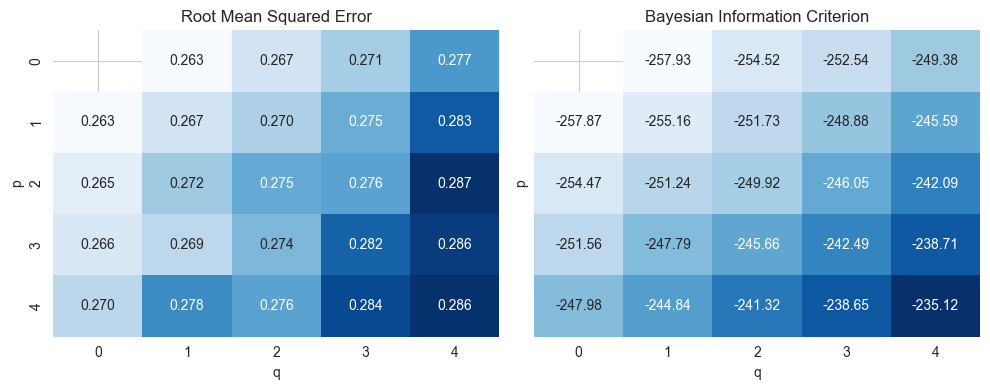

In [59]:
bitcoin_results_df.index = pd.MultiIndex.from_tuples(bitcoin_results_df.index, names=["p", "q"])

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(bitcoin_results_df[bitcoin_results_df.RMSE<.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(bitcoin_results_df.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

In [61]:
bitcoin_results_df.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

p  q
1  0    1.5
0  1    1.5
2  0    4.0
1  1    4.0
0  2    5.0
dtype: float64

In [62]:
best_p, best_q = bitcoin_results_df.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [63]:
best_bitcoin_model = tsa.ARIMA(endog=bitcoin_df['close_diff'], order=(best_p, 0, best_q)).fit()
print(best_bitcoin_model.summary())

                               SARIMAX Results                                
Dep. Variable:             close_diff   No. Observations:                  299
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 658.950
Date:                Wed, 02 Jul 2025   AIC                          -1311.899
Time:                        22:18:17   BIC                          -1300.798
Sample:                    07-25-2024   HQIC                         -1307.456
                         - 05-19-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.074      0.283      -0.001       0.004
ar.L1         -0.0650      0.051     -1.284      0.199      -0.164       0.034
sigma2         0.0007   4.15e-05     17.190      0.0

# Bitcoin ARIMA Diagnostics Summary

### Ljung-Box Test  
Checks for autocorrelation in the residuals. The high p-value of (0.95) means we fail to reject the null of no autocorrelation. This suggests the residuals are similar to white noise, meaning the ARIMA model has removed time dependencies.

### Jarque-Bera Test  
Checks whether the residuals are normally distributed. A p-value of 0.00 indicates strong evidence against normality. The residuals are slightly right-skewed (0.40), which makes sense given that Bitcoin returns are generally more positive than negative during a bull market. The distribution of returns is also leptokurtic (5.11), meaning heavy tails. This is to be expected for financial time series data.

### Heteroskedasticity Test  
Checks for changing variance in the residuals (heteroskedasticity). A p-value of (0.65) means we fail to reject the null of homoskedasticity. This implies that residuals have constant variance on average (but volatility clustering is still a possibility that I wouldn't rule out).


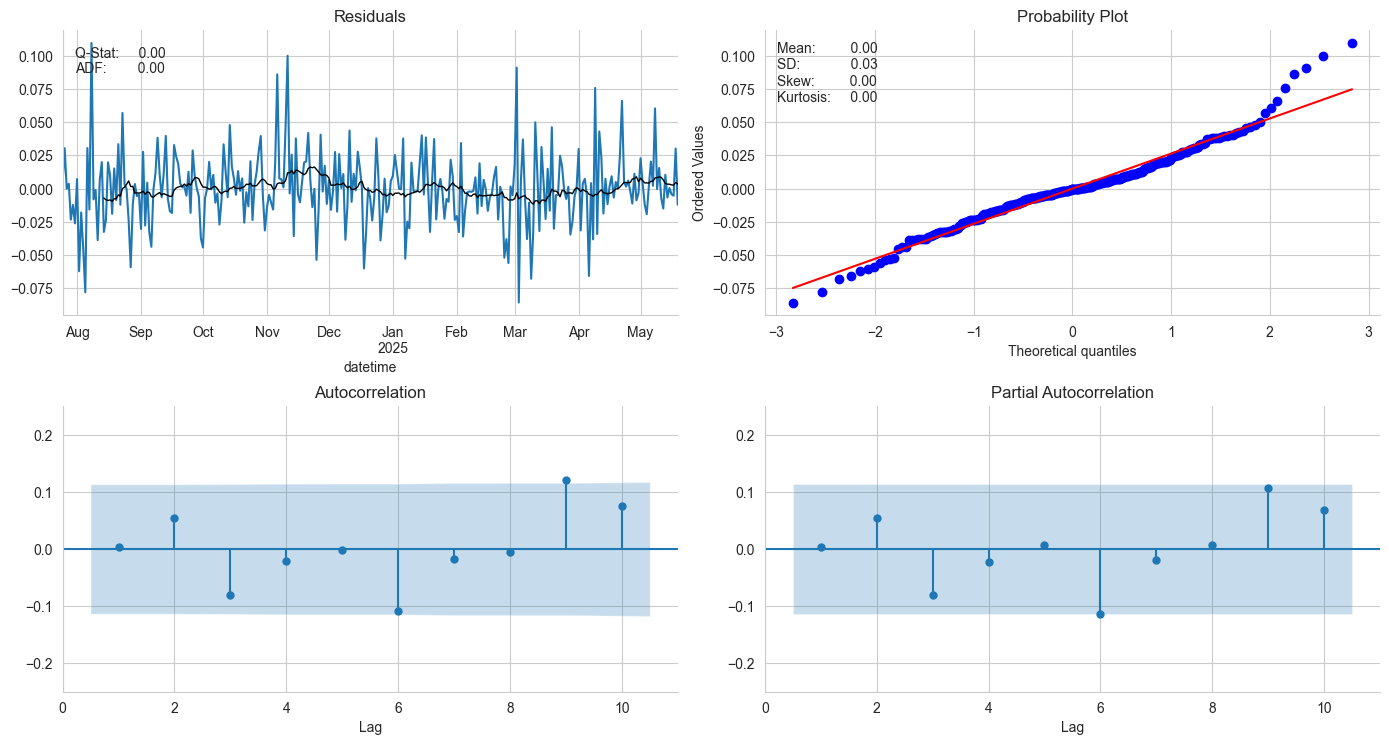

In [66]:
plot_correlogram(best_bitcoin_model.resid, ylim=(-0.25, 0.25))

In [53]:
air_results_df = grid_search_arima(air_passenger_df['passengers_diff'])

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [54]:
air_results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, (3, 3) to (0, 2)
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RMSE                 24 non-null     float64
 1   AIC                  24 non-null     float64
 2   BIC                  24 non-null     float64
 3   Convergence_Errors   24 non-null     int64  
 4   Stationarity_Errors  24 non-null     int64  
dtypes: float64(3), int64(2)
memory usage: 1.1+ KB


In [55]:
air_results_df.nsmallest(5, columns=['RMSE'])

,RMSE,AIC,BIC,Convergence_Errors,Stationarity_Errors
"(3, 3)",0.093534,-45.255721,-34.317354,0,0
"(0, 4)",0.094825,-46.781115,-38.577340,0,0
"(2, 4)",0.096466,-45.266610,-34.328244,0,0
"(3, 4)",0.096951,-43.770597,-31.464935,0,0
"(2, 1)",0.097185,-45.554595,-38.718116,0,0


In [56]:
air_results_df.nsmallest(5, columns=['BIC'])

,RMSE,AIC,BIC,Convergence_Errors,Stationarity_Errors
"(0, 1)",0.107655,-44.052218,-39.950330,0,0
"(0, 2)",0.109832,-44.833679,-39.364496,0,0
"(1, 0)",0.106201,-43.379343,-39.277455,0,0
"(1, 1)",0.104685,-44.243480,-38.774297,0,0
"(1, 2)",0.103091,-45.593815,-38.757336,0,0


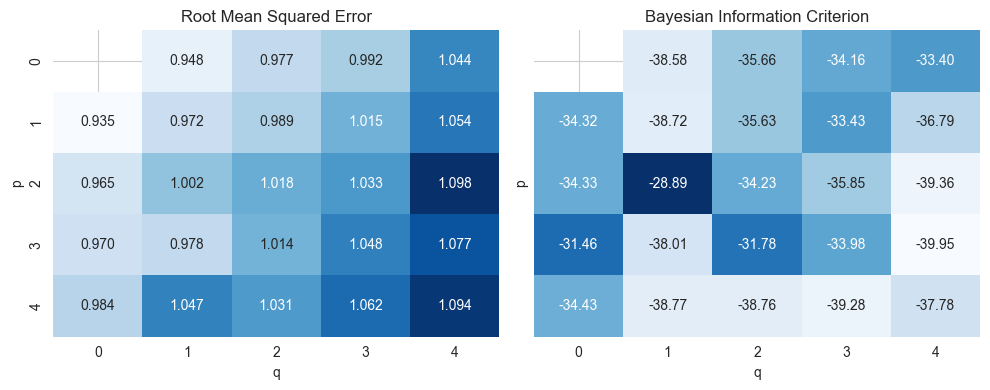

In [75]:
air_results_df.index = pd.MultiIndex.from_tuples(air_results_df.index, names=["p", "q"])

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(air_results_df[air_results_df.RMSE<.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(air_results_df.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

In [67]:
air_results_df.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

p  q
0  1    4.5
1  1    5.5
3  1    7.5
1  0    8.5
2  0    9.0
dtype: float64

In [68]:
best_p, best_q = air_results_df.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [71]:
best_air_model = tsa.ARIMA(endog=air_passenger_df['passengers_diff'], order=(best_p, 0, best_q)).fit()
print(best_air_model.summary())

                               SARIMAX Results                                
Dep. Variable:        passengers_diff   No. Observations:                  143
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 121.754
Date:                Thu, 03 Jul 2025   AIC                           -237.507
Time:                        07:47:34   BIC                           -228.619
Sample:                    02-01-1949   HQIC                          -233.895
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.012      0.828      0.407      -0.013       0.033
ma.L1          0.2722      0.105      2.602      0.009       0.067       0.477
sigma2         0.0107      0.002      5.997      0.0

# Airline ARIMA Diagnostics Summary

### Ljung-Box Test  
Checks for autocorrelation in the residuals. The p-value of 0.73 means we fail to reject the null of no autocorrelation. This suggests there is no strong evidence of remaining autocorrelation, but given the nature of airline passenger data, seasonal effects may still be present and not fully captured by the current ARIMA model.

### Jarque-Bera Test  
Checks whether the residuals are normally distributed. A p-value of 0.04 indicates moderate evidence against normality. The residuals are slightly right-skewed (0.21), and the kurtosis is 2.05, which is close to the normal distribution value of 3. This suggests the residuals are mildly non-normal, but not dramatically so.

### Heteroskedasticity Test  
Checks for changing variance in the residuals (heteroskedasticity). A p-value of 0.60 means we fail to reject the null of homoskedasticity. This implies that the residuals have constant variance on average. However, given the nature of seasonal data, volatility patterns could still vary across cycles.



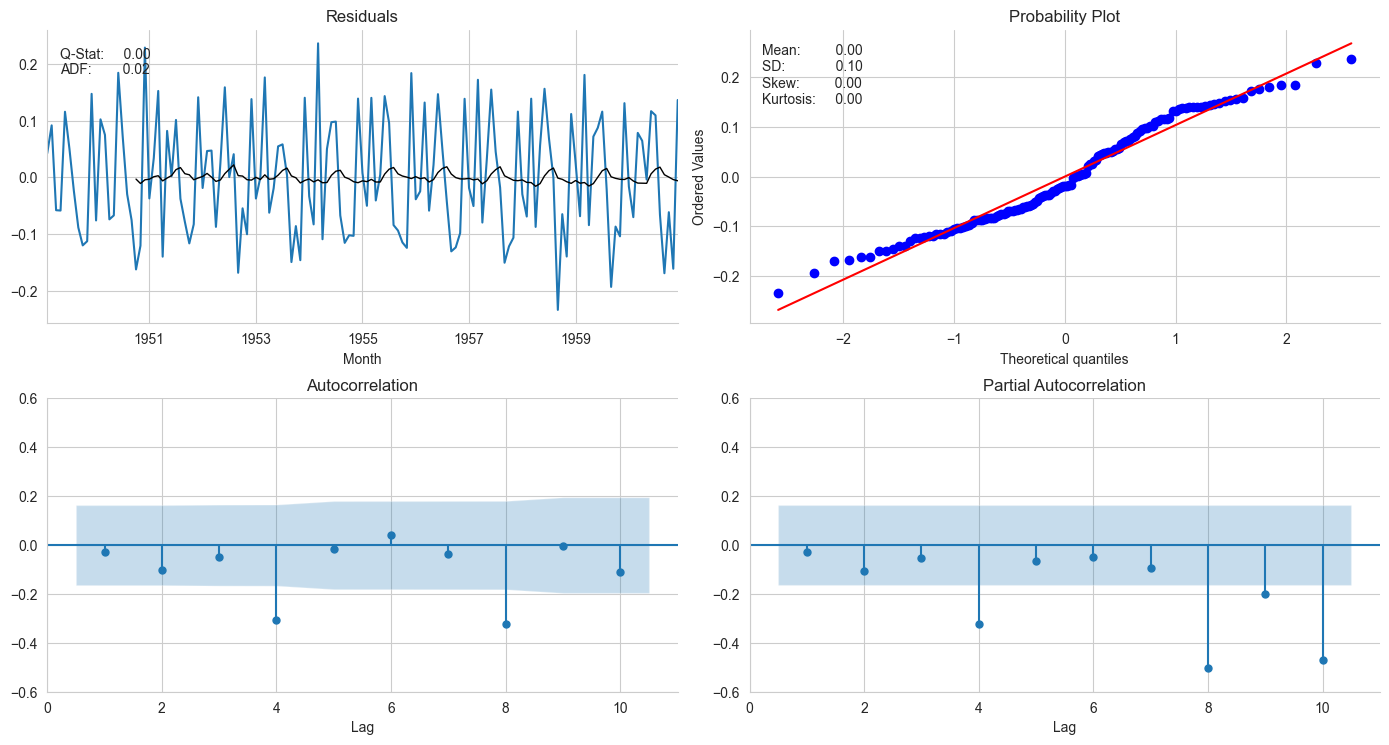

In [74]:
plot_correlogram(best_air_model.resid, ylim=(-0.6, 0.6))